Importing required libraries

In [1]:
import os
# disable tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook

# Sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
# function to compute class weights
from sklearn.utils import compute_class_weight

#Matplotlib
import matplotlib.pyplot as plt

# Data management libraries
import scipy.io as scio
import numpy as np

Loading in the data

In [37]:
Training_tumor_data = scio.loadmat('Data/tumor_training.mat')
Testing_tumor_data = scio.loadmat('Data/tumor_testing.mat')

N = 64 # image size (64x64 after preprocessing)
num_classes = 4; # how many different types of classifications we have 

Visualisartion of data

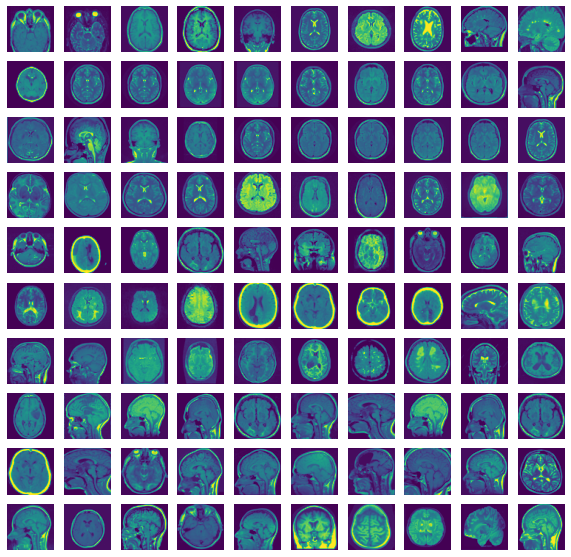

In [38]:
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(Training_tumor_data['images_train'][:,:,i])
    ax.axis('off')

(2870, 64, 64, 1)
(2870, 1)
(394, 64, 64, 1)
(394, 1)


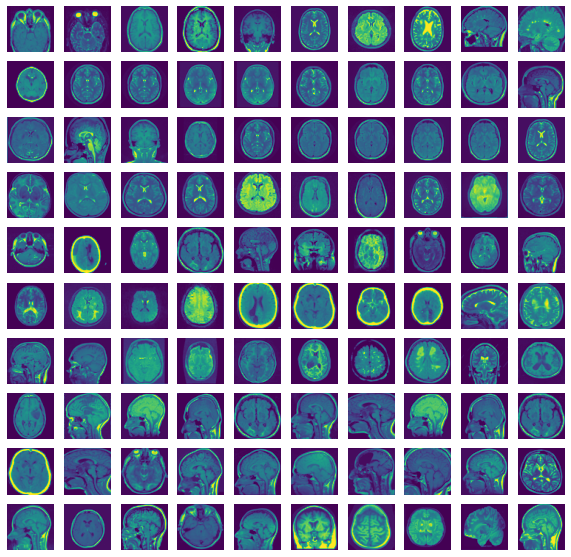

In [39]:
train = np.transpose(Training_tumor_data['images_train'], (2, 0, 1)).reshape(-1, N, N, 1)
train_y = np.transpose(Training_tumor_data['labels_tr'])
test = np.transpose(Testing_tumor_data['images_test'], (2, 0, 1)).reshape(-1, N, N, 1)
test_y = np.transpose(Testing_tumor_data['labels_te'])

print(train.shape)
print(train_y.shape)
print(test.shape)
print(test_y.shape)

fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(train[i,:,:,0])
    ax.axis('off')    

Network Architecture

In [44]:
num_epochs = 25 # how many training epochs we are doing

# build model function
def build_model(num_classes, output_activation=None):
    # Input in an image shape
    inputs = keras.Input(shape=(N, N, 1, ), name='img')
    
    # run pairs of conv layers, all 3s3 kernels
    x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(inputs) # consider using alternate activation
    x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation=None)(x)
    # batch normalisation, before the non-linearity
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # spatial dropout, this will drop whole kernels, i.e. 20% of our 3x3 filters will be dropped out rather
    # than dropping out 20% of the invidual pixels
    x = layers.SpatialDropout2D(0.2)(x)
    # max pooling, 2x2, which will downsample the image
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    # rinse and repeat with 2D convs, batch norm, dropout and max pool
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x) # consider using alternate activation
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.2)(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    # final conv2d, batch norm and spatial dropout
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x) # consider using alternate activation
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.2)(x)

    # flatten layer
    x = layers.Flatten()(x)
    
    # Neuron setup
    x = layers.Dense(256, activation='relu')(x) # consider using alternate activation
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x) # consider using alternate activation
    
    # the output
    outputs = layers.Dense(num_classes, activation=output_activation)(x)

    # build the model, and print a summary
    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='tumor_classifier_cnn_model')
    
    return model_cnn

In [45]:
model_cnn = build_model(num_classes)
model_cnn.summary()

Model: "tumor_classifier_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 64, 8)         80        
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 8)         584       
                                                                 
 batch_normalization_9 (Batc  (None, 64, 64, 8)        32        
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 64, 64, 8)         0         
                                                                 
 spatial_dropout2d_9 (Spatia  (None, 64, 64, 8)        0         
 lDropout2D)                            

Training the model

In [46]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(train, train_y,
                        batch_size=156,
                        epochs=num_epochs,
                        validation_data=(test, test_y))

Epoch 1/25
19/19 [==============================] - 4s 214ms/step - loss: 2.0965 - accuracy: 0.3429 - val_loss: 1.3911 - val_accuracy: 0.2259
Epoch 2/25
19/19 [==============================] - 4s 212ms/step - loss: 1.0978 - accuracy: 0.5077 - val_loss: 1.3894 - val_accuracy: 0.2234
Epoch 3/25
19/19 [==============================] - 4s 217ms/step - loss: 0.9033 - accuracy: 0.5962 - val_loss: 1.4033 - val_accuracy: 0.2538
Epoch 4/25
19/19 [==============================] - 4s 208ms/step - loss: 0.8514 - accuracy: 0.6226 - val_loss: 1.3975 - val_accuracy: 0.2538
Epoch 5/25
19/19 [==============================] - 4s 207ms/step - loss: 0.7927 - accuracy: 0.6401 - val_loss: 1.3921 - val_accuracy: 0.2411
Epoch 6/25
19/19 [==============================] - 4s 208ms/step - loss: 0.7473 - accuracy: 0.6693 - val_loss: 1.4111 - val_accuracy: 0.2741
Epoch 7/25
19/19 [==============================] - 4s 207ms/step - loss: 0.6898 - accuracy: 0.6864 - val_loss: 1.4181 - val_accuracy: 0.2208
Epoch 

Model Evaluation

              precision    recall  f1-score   support

           0       0.59      0.74      0.66       105
           1       0.41      0.28      0.33       100
           2       0.67      0.70      0.68       115
           3       0.58      0.57      0.57        74

    accuracy                           0.58       394
   macro avg       0.56      0.57      0.56       394
weighted avg       0.56      0.58      0.57       394



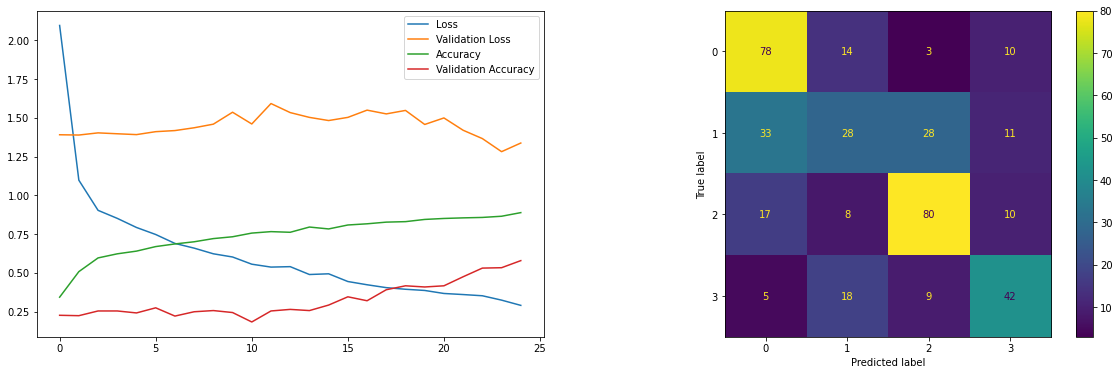

In [47]:
def eval_model(model, history, x_train, y_train, x_test, y_test):

    fig = plt.figure(figsize=[20, 6])    

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history['loss'], label='Loss')
    ax.plot(history['val_loss'], label='Validation Loss')
    ax.plot(history['accuracy'], label='Accuracy')
    ax.plot(history['val_accuracy'], label='Validation Accuracy')
    ax.legend()
    
    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    cm = confusion_matrix(y_test, indexes)

    ax = fig.add_subplot(1, 2, 2)
    c = ConfusionMatrixDisplay(cm, display_labels=range(len(np.unique(y_test))))
    c.plot(ax = ax)
    
    print(classification_report(y_test, indexes))

eval_model(model_cnn, history.history, train, train_y, test, test_y)